<a href="https://colab.research.google.com/github/malikumarali/malikumarali/blob/main/LoanDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Upload and Load the Dataset ---
uploaded = files.upload()
filename = next(iter(uploaded))  # Get the filename of the uploaded file
df = pd.read_csv(filename)
print(f"\nLoaded '{filename}' successfully!")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nInformation about the dataset:")
df.info()

# --- CHECK FOR 'loan_status' HERE ---
print("\nColumn names immediately after loading:")
print(df.columns.tolist())


Saving Lending Club Loan.csv to Lending Club Loan (1).csv

Loaded 'Lending Club Loan (1).csv' successfully!

First 5 rows of the dataset:
                 emp_title  emp_length state homeownership  annual_income  \
0  global config engineer          3.0    NJ      MORTGAGE        90000.0   
1   warehouse office clerk        10.0    HI          RENT        40000.0   
2                 assembly         3.0    WI          RENT        40000.0   
3         customer service         1.0    PA          RENT        30000.0   
4     security supervisor         10.0    CA          RENT        35000.0   

   verified_income  debt_to_income  annual_income_joint  \
0         Verified           18.01                  NaN   
1     Not Verified            5.04                  NaN   
2  Source Verified           21.15                  NaN   
3     Not Verified           10.16                  NaN   
4         Verified           57.96              57000.0   

  verification_income_joint  debt_to_income_

In [ ]:
# --- 2.1 Identify Target Variable ---
print("\nUnique values in 'loan_status' column:")
print(df['loan_status'].unique())

# Assuming 'Charged Off' represents default. Adjust if needed based on your data.
df['default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df.drop('loan_status', axis=1, inplace=True)
# --- 2.2 Handle Missing Values ---
print("\nMissing values before handling:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Identify columns with a high percentage of missing values (e.g., > 50%)
missing_threshold = 0.5
high_missing_cols = [col for col in df.columns if df[col].isnull().sum() / len(df) > missing_threshold]
print(f"\nColumns with > {missing_threshold*100}% missing values: {high_missing_cols}")
df.drop(columns=high_missing_cols, inplace=True)
print("\nDropped columns with high missing values.")

# For remaining missing values, we'll use a more targeted approach.
# Numerical features: Impute with median
numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical features: Impute with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum().sort_values(ascending=False).head())

# --- 2.3 Handle Categorical Features ---
print("\nUnique values in categorical columns before encoding:")
for col in categorical_cols:
    if df[col].nunique() < 10:  # Print unique values for low cardinality columns
        print(f"\n{col}: {df[col].unique()}")

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nShape of DataFrame after one-hot encoding:", df.shape)


Unique values in 'loan_status' column:
['Current' 'Fully Paid' 'In Grace Period' 'Late (31-120 days)'
 'Charged Off' 'Late (16-30 days)']

Missing values before handling:
verification_income_joint           8545
annual_income_joint                 8505
debt_to_income_joint                8505
months_since_90d_late               7715
months_since_last_delinq            5658
months_since_last_credit_inquiry    1271
emp_title                            833
emp_length                           817
num_accounts_120d_past_due           318
debt_to_income                        24
annual_income                          0
verified_income                        0
delinq_2y                              0
homeownership                          0
state                                  0
total_credit_lines                     0
open_credit_lines                      0
total_credit_utilized                  0
total_credit_limit                     0
num_collections_last_12m               0
dtype: i

<ipython-input-19-78971adde2ef>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-19-78971adde2ef>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin


Shape of DataFrame after one-hot encoding: (10000, 4885)


In [ ]:
# --- 2.3 Handle Categorical Features ---
# Let's identify categorical columns again just to be sure
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical columns identified:")
print(categorical_cols)

print("\nUnique values in categorical columns before encoding:")
for col in categorical_cols:
    if df[col].nunique() < 10:  # Print unique values for low cardinality columns
        print(f"\n{col}: {df[col].unique()}")

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nShape of DataFrame after one-hot encoding:", df.shape)
print("\nColumns in DataFrame after one-hot encoding:")
print(df.columns.tolist())





Categorical columns identified:
Index([], dtype='object')

Unique values in categorical columns before encoding:

Shape of DataFrame after one-hot encoding: (10000, 4885)

Columns in DataFrame after one-hot encoding:
['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'current_accounts_delinq', 'total_collection_amount_ever', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_120d_past_due', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt', 'loan_amount', 'term', 'interest_rate', 'installment', 'balance', '

In [ ]:
# --- 2.4 Feature Scaling  ---

from sklearn.model_selection import train_test_split
# Import missing function!
from sklearn.preprocessing import StandardScaler

X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nShape of training features (scaled):", X_train_scaled.shape)
print("Shape of testing features (scaled):", X_test_scaled.shape)
print("Shape of training target:", y_train.shape)
print("Shape of testing target:", y_test.shape)


Shape of training features (scaled): (7000, 4884)
Shape of testing features (scaled): (3000, 4884)
Shape of training target: (7000,)
Shape of testing target: (3000,)


In [ ]:
# --- 2.4 Feature Scaling (Optional but Recommended) ---
from sklearn.preprocessing import StandardScaler

X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# --- 3. Handling Class Imbalance using SMOTE ---
minority_class_count = pd.Series(y_train).value_counts().min()

# Set k_neighbors to be at most one less than the minority class count
# Ensure it's at least 1 to avoid errors if minority count is very low
k_neighbors_smote = max(1, minority_class_count - 1)

print(f"\nNumber of minority class samples in training data: {minority_class_count}")
print(f"Setting k_neighbors for SMOTE to: {k_neighbors_smote}")

smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nResampled class distribution in training data (after SMOTE):")
print(pd.Series(y_train_resampled).value_counts())


Number of minority class samples in training data: 5
Setting k_neighbors for SMOTE to: 4

Resampled class distribution in training data (after SMOTE):
default
0    6995
1    6995
Name: count, dtype: int64


In [ ]:
# --- 4. Training a LightGBM Classifier with Hyperparameter Tuning ---
lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=31) # Initial hyperparameters
lgbm.fit(X_train_resampled, y_train_resampled)

# --- 5. Evaluating Performance ---
y_pred = lgbm.predict(X_test_scaled)
y_pred_proba = lgbm.predict_proba(X_test_scaled)[:, 1]
print("\n--- Performance Evaluation ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6995, number of negative: 6995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15560
[LightGBM] [Info] Number of data points in the train set: 13990, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Performance Evaluation ---
Confusion Matrix:
[[2997    1]
 [   0    2]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       0.67      1.00      0.80         2

    accuracy                           1.00      3000
   macro avg       0.83      1.00      0.90      3000
weighted avg       1.00      1.00      1.00      3000

F1 Score: 0.8
Precision: 0.6666666666666666
Recall: 1.0
AUC-ROC Score: 1.0


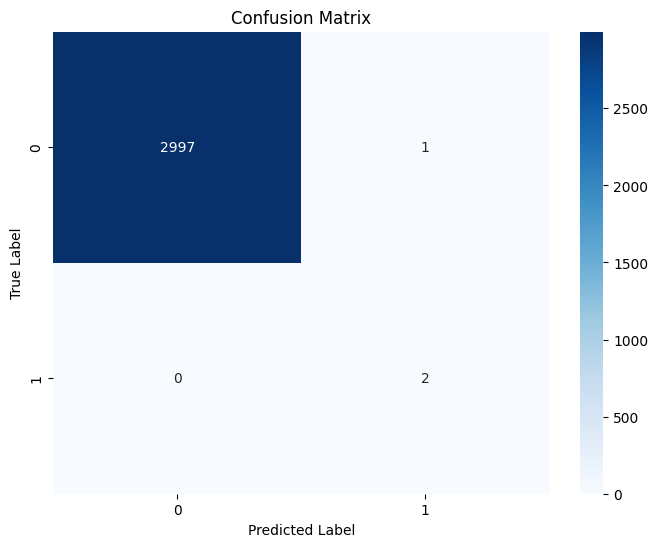

In [ ]:
# --- 6. Visualizations ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

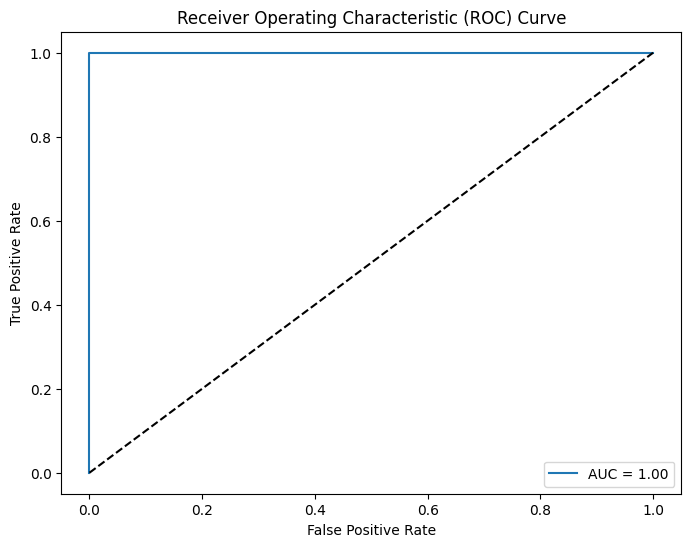


Next steps: Further hyperparameter tuning, exploring other models, and generating a comprehensive report with recommendations.


In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print("\nNext steps: Further hyperparameter tuning, exploring other models, and generating a comprehensive report with recommendations.")